In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, random_split
from model import MLP
from dataset import BurgersDataset
from config import (
    DATA_DIR,
    MODEL_PATH,
    INPUT_SIZE,
    HIDDEN_SIZE,
    OUTPUT_SIZE,
    EPOCHS,
    BATCH_SIZE,
    LR,
    SPLIT,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
import matplotlib.pyplot as plt
import numpy as np

In [7]:
dataset = BurgersDataset(data_dir=DATA_DIR)
train_size = int(SPLIT * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

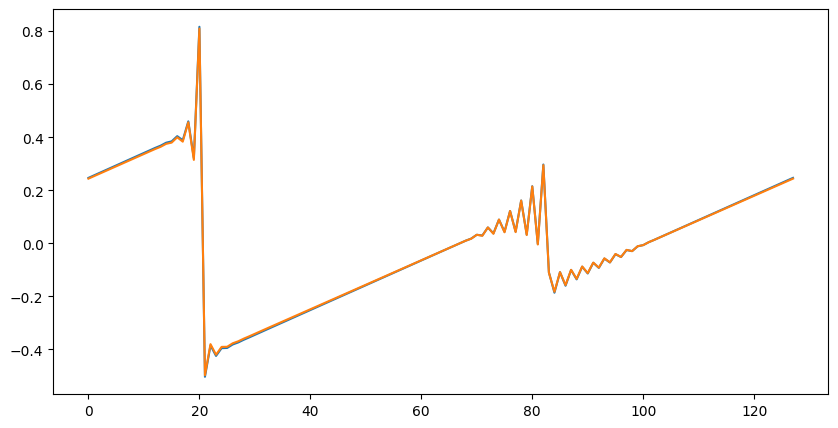

In [8]:
#sample the train_loader
sample = next(iter(train_loader))

x, y = sample
#plot 
plt.figure(figsize=(10,5))
plt.plot(x[0].numpy(), label='Input')
plt.plot(y[0].numpy(), label='Target')

In [26]:
class MLP_RES(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP_RES, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
        self.identity_proj = torch.ones(input_size, hidden_size, requires_grad=False) if input_size != hidden_size else None
        self.identity_proj /= (hidden_size/input_size) # scaling

    def to(self, device):
        self.identity_proj = self.identity_proj.to(device) if self.identity_proj is not None else None
        return super().to(device)

    def forward(self, x):
        input = x
        
        out = F.relu(self.fc1(input))
        if self.identity_proj is not None:
            identity = input @ self.identity_proj
        out = out + identity
        
        out = F.relu(self.fc2(out))
        out = out + identity
        
        out = self.fc3(out)
        out = out + input

        return out

# model = MLP_RES(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, output_size=OUTPUT_SIZE)
# model.to(device)


# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=5e-6)

# model.eval()
# with torch.no_grad():
#     x, y = next(iter(val_loader))
#     y_pred = model(x)
#     val_loss = criterion(y_pred, y).item()
# print(f"{val_loss}")

In [28]:
def train(criterion, optimizer, scheduler, model, train_loader, val_loader, device):
    loss_history = {"train": [], "val": []}
    print("Starting training...")

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = y.to(device)
                y_pred = model(x)
                val_loss += criterion(y_pred, y).item()

        avg_train = train_loss / len(train_loader)
        avg_val = val_loss / len(val_loader)
        
        # Get the current learning rate from the optimizer
        current_lr = optimizer.param_groups[0]['lr']
        
        print(
            f"Epoch {epoch+1}/{EPOCHS}, "
            f"Train Loss: {avg_train:.6f}, "
            f"Val Loss: {avg_val:.6f}, "
            f"LR: {current_lr:.8f}"
        )

        loss_history["train"].append(avg_train)
        loss_history["val"].append(avg_val)

        # Step the scheduler at the end of each epoch
        scheduler.step()

    print("Finished training.")

    return loss_history

In [ ]:
LR = 1e-4
EPOCHS = 250

model = MLP_RES(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, output_size=OUTPUT_SIZE)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-8)

loss_history = train(criterion, optimizer, scheduler, model, train_loader, val_loader, device)

torch.save(model.state_dict(), "models/MLP_RES.pth")
print(f"Model saved")

Starting training...
Epoch 1/250, Train Loss: 0.029368, Val Loss: 0.007263, LR: 0.00010000
Epoch 2/250, Train Loss: 0.006178, Val Loss: 0.006555, LR: 0.00010000
Epoch 3/250, Train Loss: 0.005735, Val Loss: 0.006163, LR: 0.00009998
Epoch 4/250, Train Loss: 0.005465, Val Loss: 0.005978, LR: 0.00009996
Epoch 5/250, Train Loss: 0.005293, Val Loss: 0.005908, LR: 0.00009994
Epoch 6/250, Train Loss: 0.005177, Val Loss: 0.005918, LR: 0.00009990
Epoch 7/250, Train Loss: 0.005068, Val Loss: 0.005670, LR: 0.00009986
Epoch 8/250, Train Loss: 0.004986, Val Loss: 0.005648, LR: 0.00009981
Epoch 9/250, Train Loss: 0.004948, Val Loss: 0.005653, LR: 0.00009975
Epoch 10/250, Train Loss: 0.004926, Val Loss: 0.005530, LR: 0.00009968
Epoch 11/250, Train Loss: 0.004909, Val Loss: 0.005521, LR: 0.00009961
Epoch 12/250, Train Loss: 0.004907, Val Loss: 0.005453, LR: 0.00009952
Epoch 13/250, Train Loss: 0.004824, Val Loss: 0.005473, LR: 0.00009943
Epoch 14/250, Train Loss: 0.004761, Val Loss: 0.005584, LR: 0.000

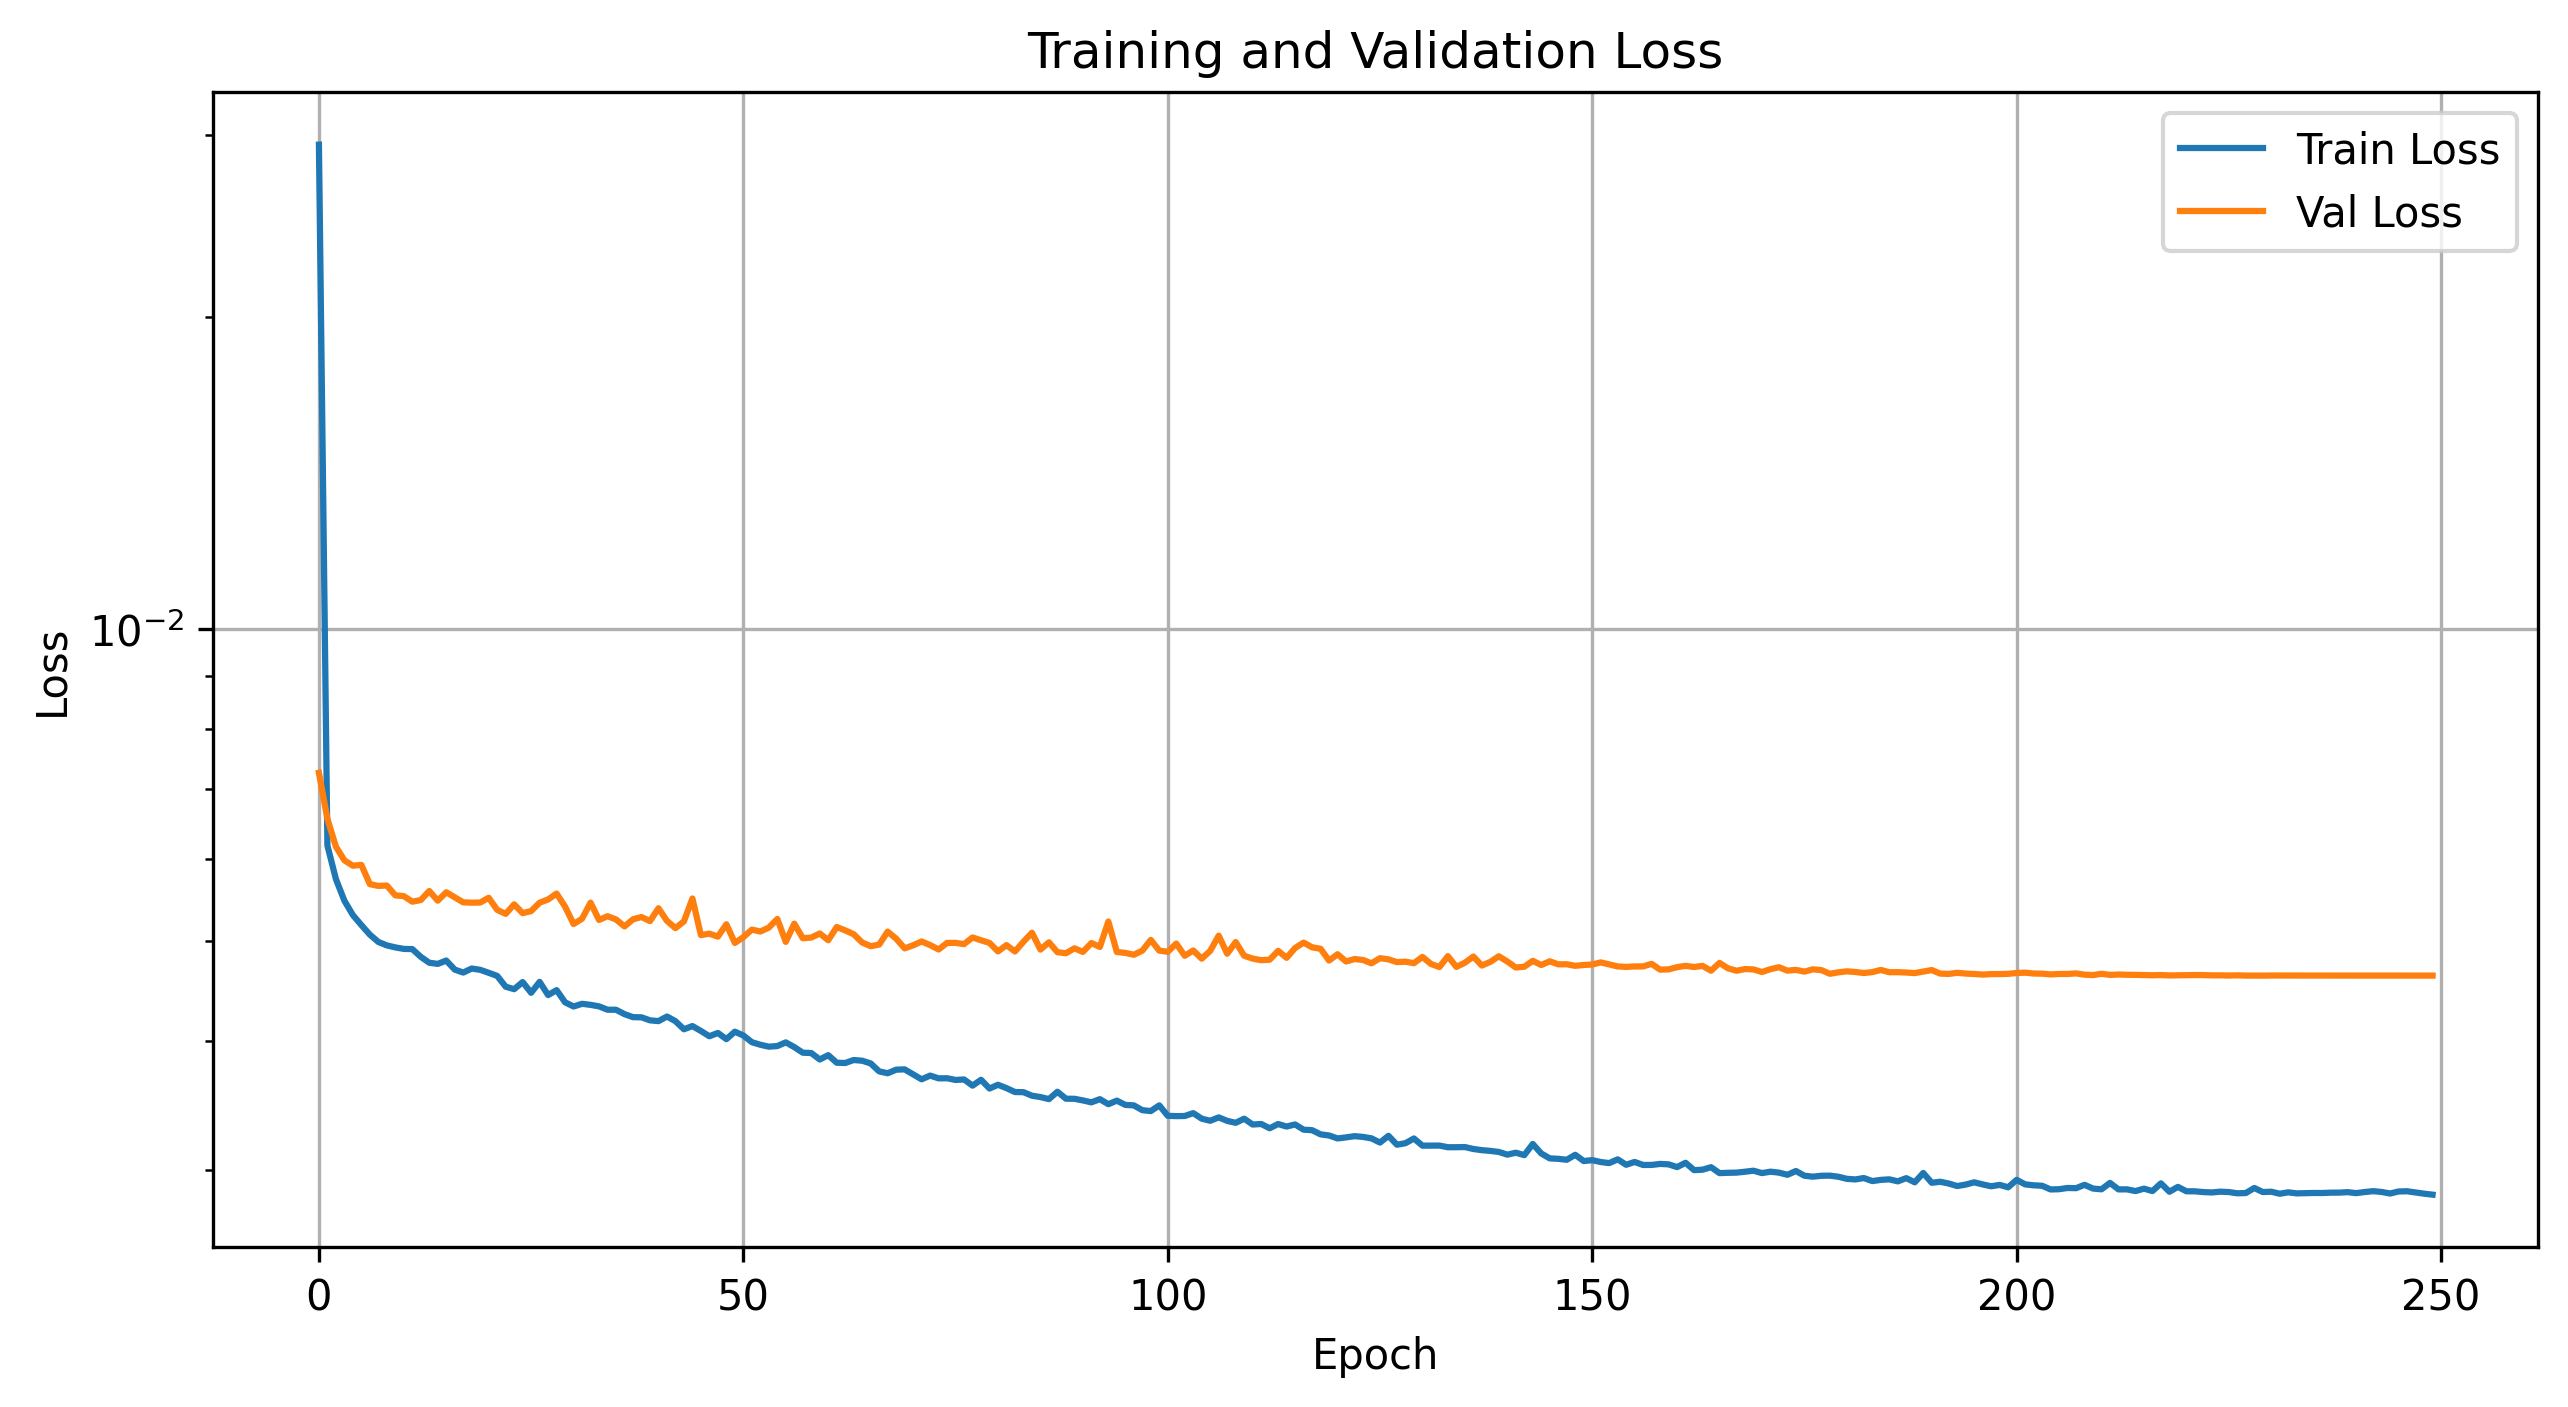

In [ ]:
plt.figure(figsize=(8, 4), dpi=300)
plt.plot(loss_history["train"], label="Train Loss")
plt.plot(loss_history["val"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.yscale("log")
plt.tight_layout()
plt.grid()
plt.legend()
plt.show()

In [30]:
class ResidualBlock1D(nn.Module):
    """A standard 1D residual block."""
    def __init__(self, channels, kernel_size=3):
        super(ResidualBlock1D, self).__init__()
        padding = (kernel_size - 1) // 2
        self.conv1 = nn.Conv1d(channels, channels, kernel_size, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm1d(channels)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm1d(channels)

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity # Residual connection
        return F.relu(out)

class CNN_RES(nn.Module):

    def __init__(self, hidden_channels, num_blocks=2, kernel_size=3):
        super(CNN_RES, self).__init__()
        # Input layer: maps 1 input channel to hidden_channels
        self.conv_in = nn.Conv1d(1, hidden_channels, kernel_size=1, bias=False)
        self.bn_in = nn.BatchNorm1d(hidden_channels)
        
        # A sequence of residual blocks operating on hidden_channels
        layers = [ResidualBlock1D(hidden_channels, kernel_size) for _ in range(num_blocks)]
        self.res_blocks = nn.Sequential(*layers)
        
        # Output layer: maps hidden_channels back to 1 output channel
        self.conv_out = nn.Conv1d(hidden_channels, 1, kernel_size=1)

    def add_input_channel(self, x):
        return x.unsqueeze(1)
    
    def remove_channel(self, x):
        return x.squeeze(1)

    def forward(self, x):
        out = self.add_input_channel(x)
        out = F.relu(self.bn_in(self.conv_in(out)))
        out = self.res_blocks(out)
        out = self.conv_out(out)
        return self.remove_channel(out)

In [ ]:
NUM_RES_BLOCKS = 4
KERNEL_SIZE = 5

model = CNN_RES(
    hidden_channels=HIDDEN_SIZE,
    num_blocks=NUM_RES_BLOCKS,
    kernel_size=KERNEL_SIZE
)
model.to(device)

LR = 1e-4
EPOCHS = 250

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-8)

loss_history = train(criterion, optimizer, scheduler, model, train_loader, val_loader, device)

torch.save(model.state_dict(), "models/CNN_RES.pth")
print(f"Model saved")

Starting training...
Epoch 1/250, Train Loss: 0.098357, Val Loss: 0.019686, LR: 0.00010000
Epoch 2/250, Train Loss: 0.014139, Val Loss: 0.007526, LR: 0.00010000
Epoch 3/250, Train Loss: 0.012378, Val Loss: 0.009055, LR: 0.00009998
Epoch 4/250, Train Loss: 0.011946, Val Loss: 0.011771, LR: 0.00009996
Epoch 5/250, Train Loss: 0.009757, Val Loss: 0.004499, LR: 0.00009994
Epoch 6/250, Train Loss: 0.009897, Val Loss: 0.003804, LR: 0.00009990
Epoch 7/250, Train Loss: 0.008947, Val Loss: 0.011493, LR: 0.00009986
Epoch 8/250, Train Loss: 0.008275, Val Loss: 0.003957, LR: 0.00009981
Epoch 9/250, Train Loss: 0.008730, Val Loss: 0.003951, LR: 0.00009975
Epoch 10/250, Train Loss: 0.006772, Val Loss: 0.004962, LR: 0.00009968
Epoch 11/250, Train Loss: 0.007020, Val Loss: 0.003551, LR: 0.00009961
Epoch 12/250, Train Loss: 0.005399, Val Loss: 0.006327, LR: 0.00009952
Epoch 13/250, Train Loss: 0.005196, Val Loss: 0.008081, LR: 0.00009943
Epoch 14/250, Train Loss: 0.004632, Val Loss: 0.003991, LR: 0.000

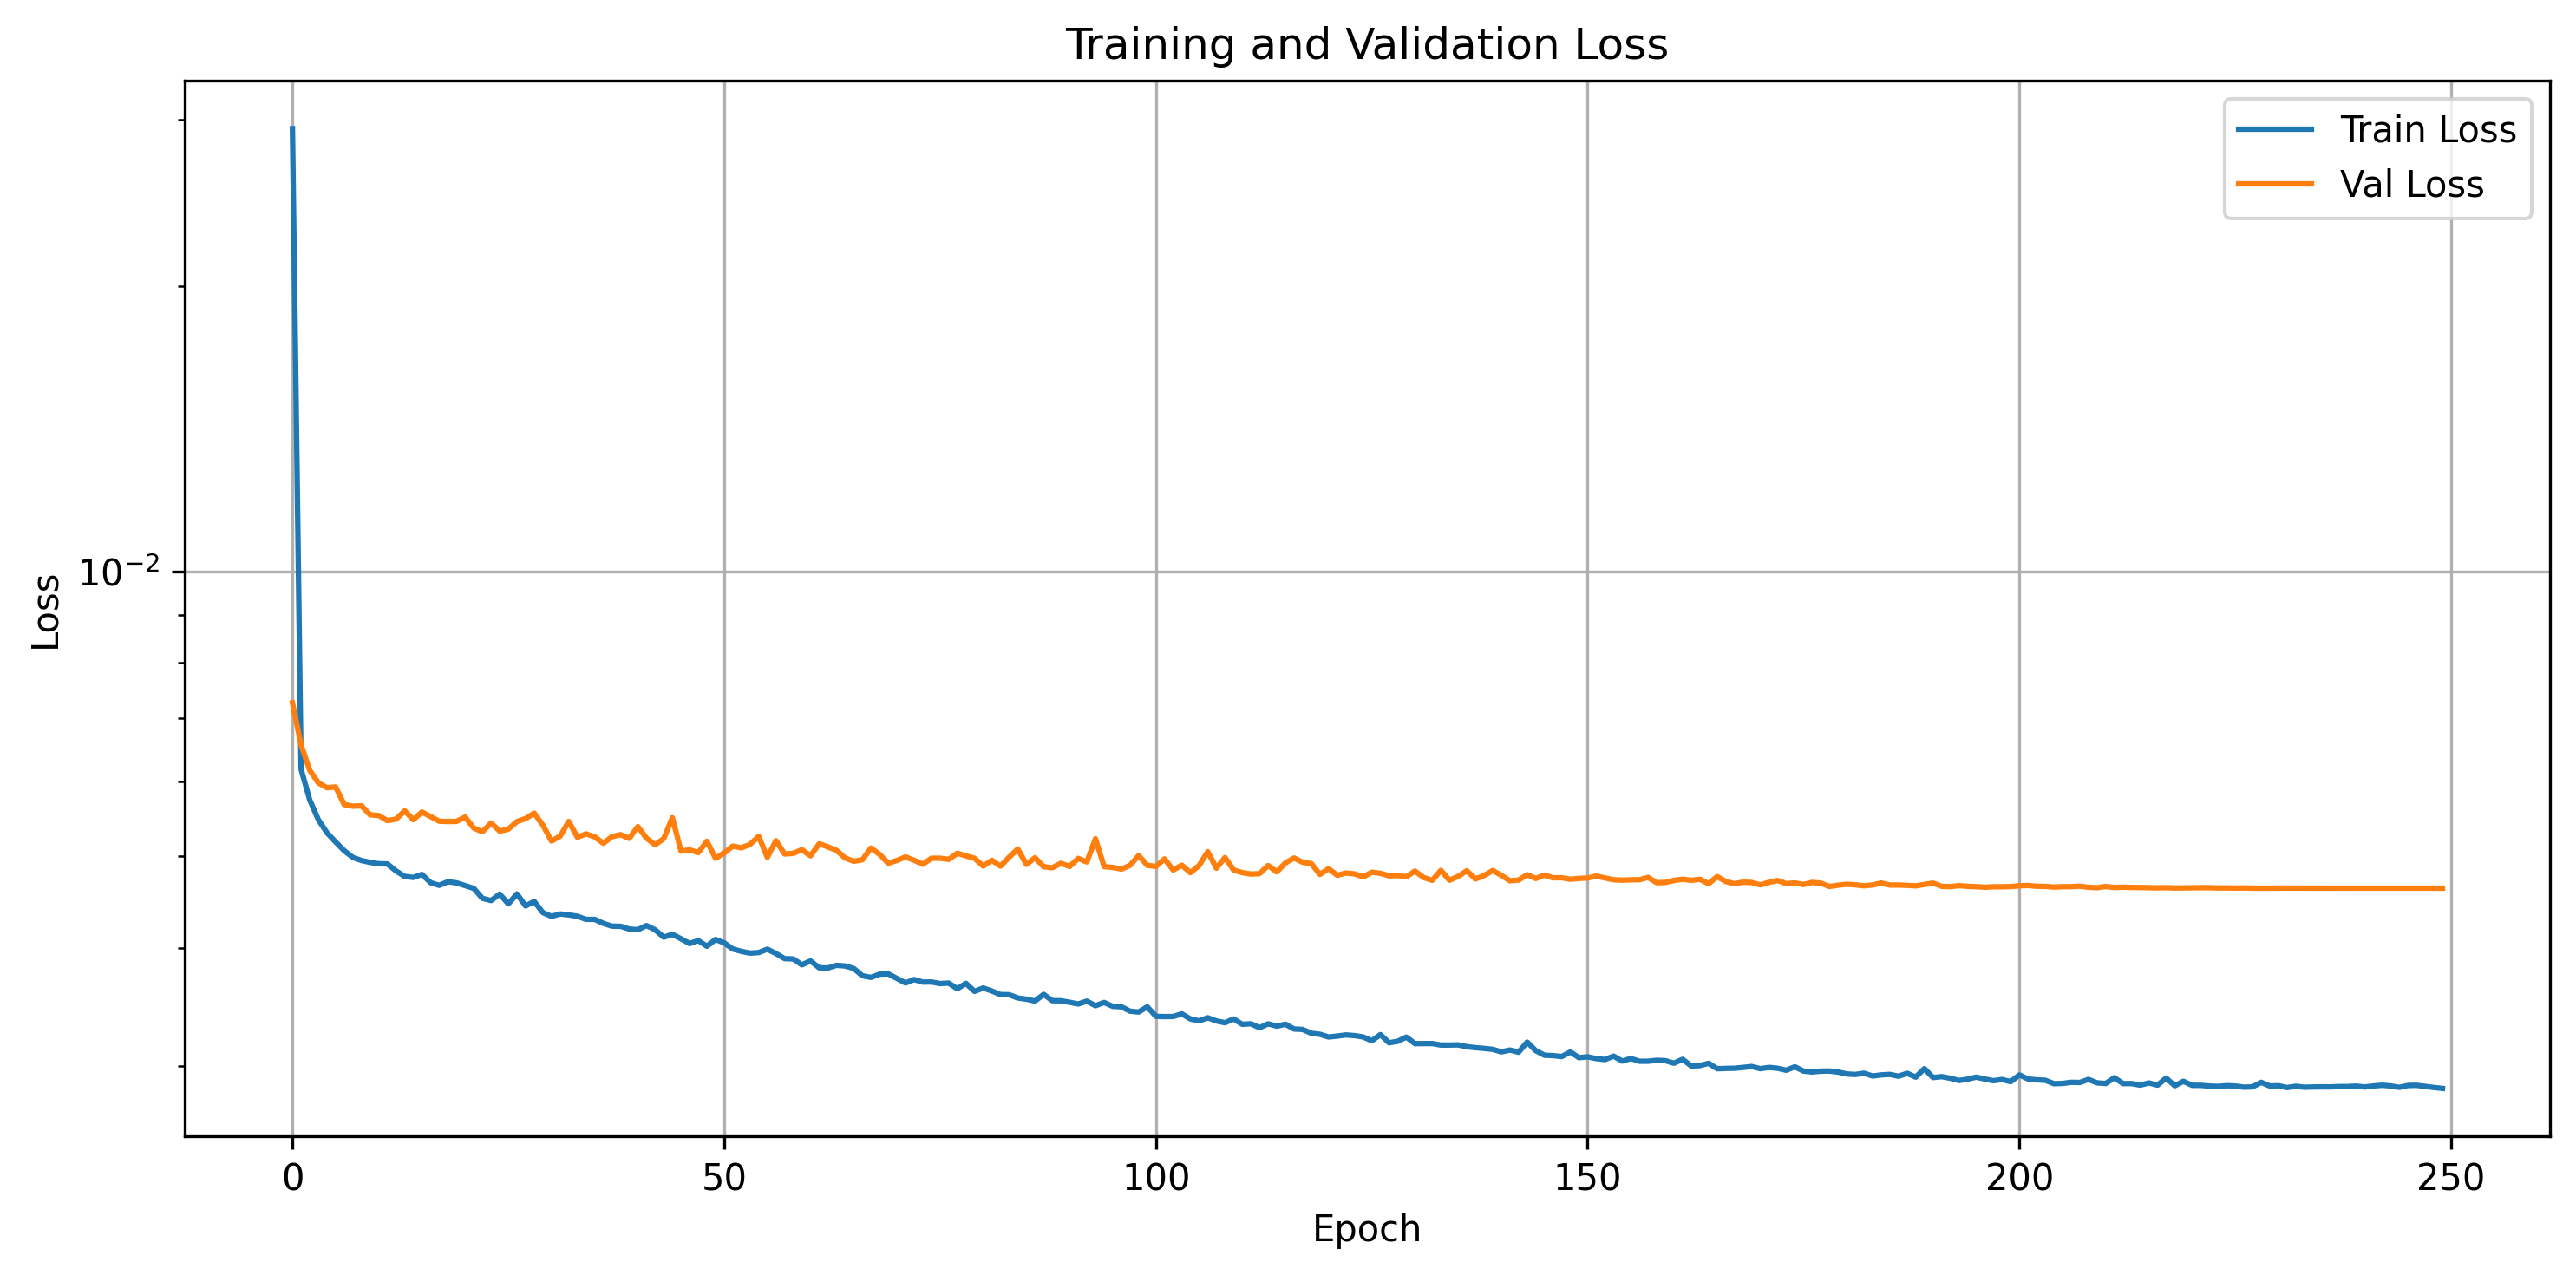

In [ ]:
plt.figure(figsize=(8, 4), dpi=300)
plt.plot(loss_history["train"], label="Train Loss")
plt.plot(loss_history["val"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.yscale("log")
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

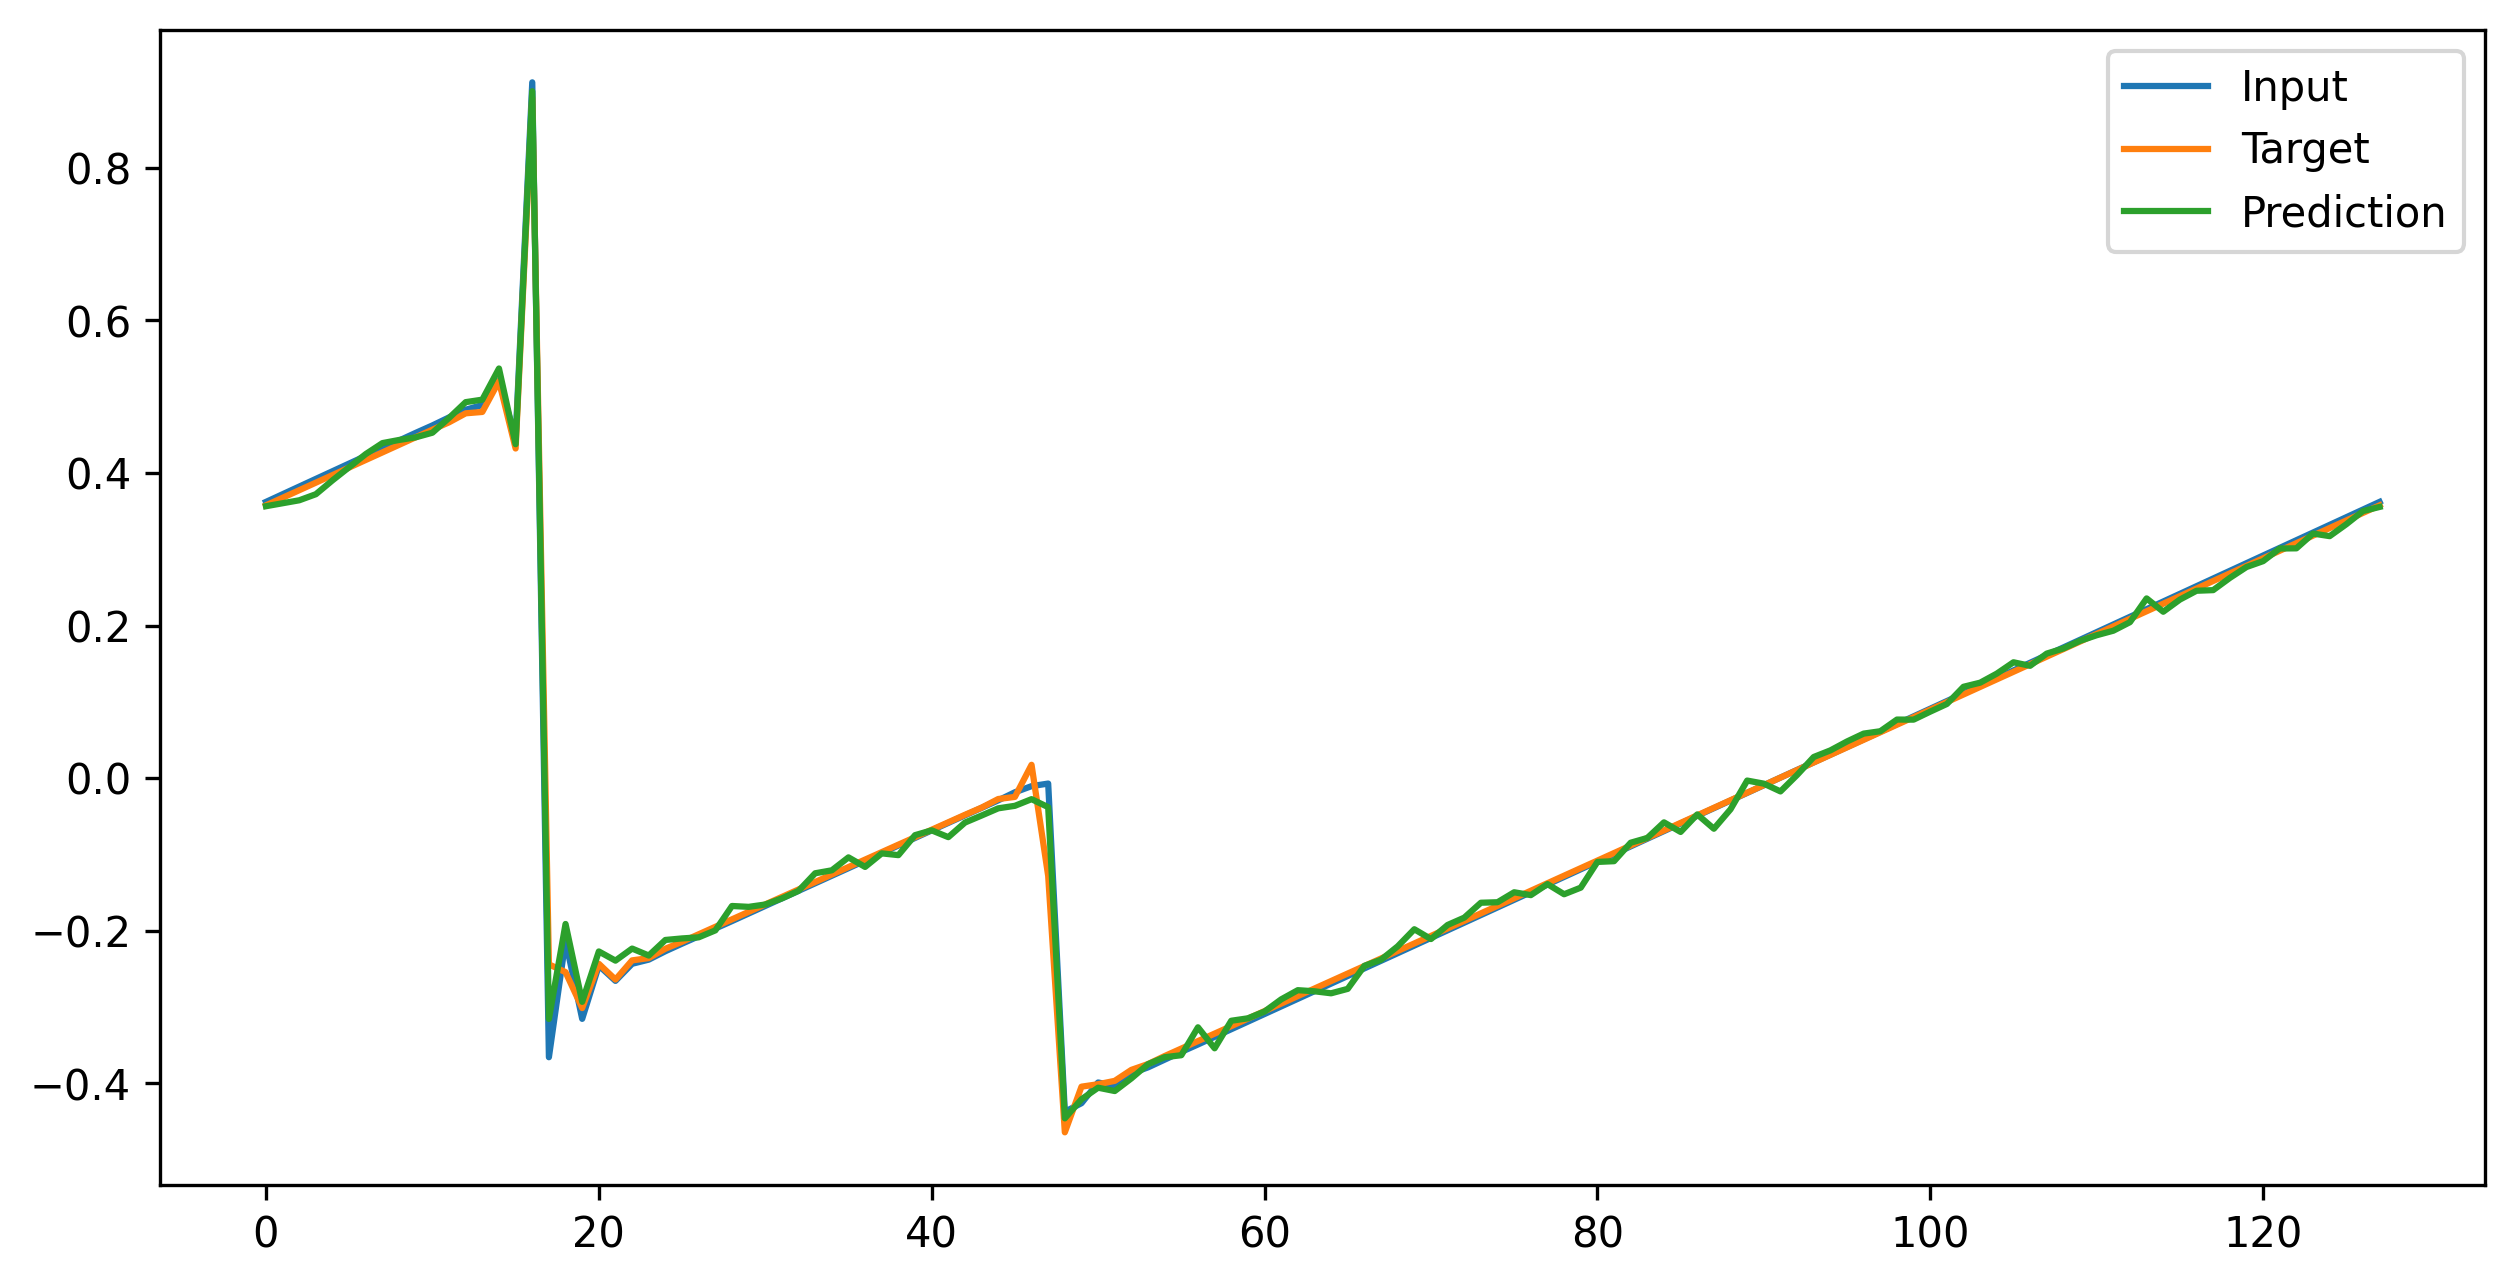

In [21]:
#sample the train_loader
sample = next(iter(train_loader))

x, y = sample

x = x.to(device)
y = y.to(device)

with torch.no_grad():
	y_pred = model(x)
	
y_pred = y_pred.cpu()
x = x.cpu()
y = y.cpu()
#plot 
plt.figure(figsize=(10,5), dpi=300)
plt.plot(x[0].numpy(), label='Input')
plt.plot(y[0].numpy(), label='Target')
plt.plot(y_pred[0], label='Prediction')
plt.legend()

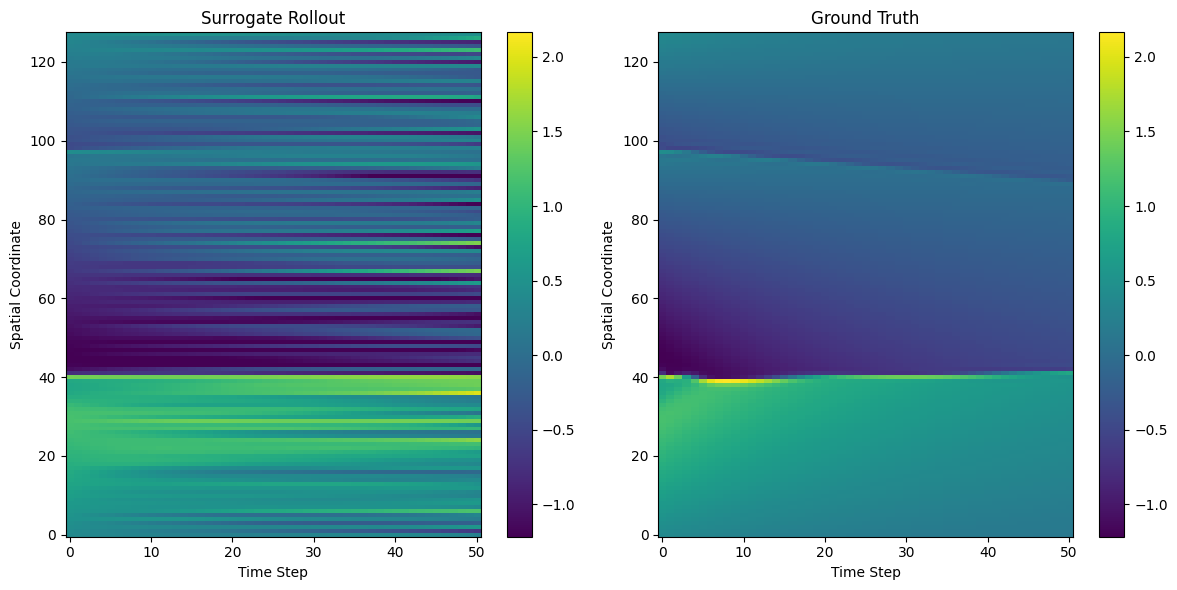

Corrected Rollout MSE over 50 steps: 0.1687


In [23]:
import numpy as np
import os
from config import EVAL_ROLLOUT_STEPS

model.eval()

npz_files = [f for f in os.listdir(DATA_DIR) if f.endswith('.npz')]
if not npz_files:
    print("No .npz files found for evaluation.")
    

data_path = os.path.join(DATA_DIR, npz_files[0])
raw_data = np.load(data_path)['DataGenerator-Mesh-1D-Internal']

rollout_steps = EVAL_ROLLOUT_STEPS

if raw_data.shape[0] <= rollout_steps:
    print(f"Data file {npz_files[0]} has only {raw_data.shape[0]} steps, not enough for a rollout of {rollout_steps} steps.")

start_index = np.random.randint(0, raw_data.shape[0] - rollout_steps - 1)

x0_np = raw_data[start_index]
ground_truth = raw_data[start_index : start_index + rollout_steps + 1]

predictions = [x0_np]
current_x = torch.from_numpy(x0_np).float().unsqueeze(0)

with torch.no_grad():
    for _ in range(rollout_steps):
        current_x = current_x.to(device)
        y_pred = model(current_x)
        predictions.append(y_pred.squeeze().cpu())
        current_x = y_pred

predictions = np.array(predictions)

vmin = ground_truth.min()
vmax = ground_truth.max()
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(predictions.T, aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
plt.title('Surrogate Rollout')
plt.xlabel('Time Step')
plt.ylabel('Spatial Coordinate')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(ground_truth.T, aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
plt.title('Ground Truth')
plt.xlabel('Time Step')
plt.ylabel('Spatial Coordinate')
plt.colorbar()

plt.tight_layout()
plt.savefig('rollout_comparison.png')
plt.show()

mse = np.mean((predictions - ground_truth)**2)
print(f"Corrected Rollout MSE over {rollout_steps} steps: {mse:.4f}")